Dataset Link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
# Dataset Paths 
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val'
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                resized_arr = resized_arr.reshape((img_size, img_size, 1))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)
# Loading training, testing, and validation data
train = get_training_data(train_dir)
test = get_training_data(test_dir)
val = get_training_data(val_dir)

OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [3]:
# Prepare data for training
x_train, y_train = [], []
x_test, y_test = [], []
x_val, y_val = [], []
for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
# Normalize data
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0
x_val = np.array(x_val) / 255.0
# Reshape for CNN (Add channel dimension for grayscale)
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_test = x_test.reshape(-1, img_size, img_size, 1)
x_val = x_val.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [4]:
# Data Augmentation for CNN
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

In [5]:
# CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 1)),
    BatchNormalization(),
    MaxPool2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    Dropout(0.1),
    BatchNormalization(),
    MaxPool2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 72, 72, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 558,273 (2.13 MB)

 Trainable params: 557,185 (2.13 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [6]:
# Reduce Learning Rate on Plateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.3, min_lr=0.000001)
# Fit CNN model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=12,
    validation_data=(x_val, y_val),
    callbacks=[learning_rate_reduction]
)

Epoch 1/12


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732736353.994686     477 service.cc:145] XLA service 0x7ace50006420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732736353.994742     477 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732736353.994765     477 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/163 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5729 - loss: 2.7144  

I0000 00:00:1732736362.881437     477 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.8189 - loss: 0.5993 - val_accuracy: 0.5000 - val_loss: 5.5365 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.8898 - loss: 0.2800 - val_accuracy: 0.5000 - val_loss: 13.6553 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9116 - loss: 0.2399 - val_accuracy: 0.5000 - val_loss: 5.6546 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9355 - loss: 0.1730 - val_accuracy: 0.6875 - val_loss: 0.4294 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9413 - loss: 0.1590 - val_accuracy: 0.5625 - val_loss: 10.2002 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9478 - loss: 0.1443 - val_accuracy: 0.6250 - val_loss: 0.5954 - learning_rate: 3.0000e-04
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9463 - loss

In [7]:
# Evaluate CNN model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Model Test Loss: {loss}")
print(f"Model Test Accuracy: {accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9527 - loss: 0.1518
Model Test Loss: 0.23153263330459595
Model Test Accuracy: 91.99%


In [8]:
# Logistic Regression Model
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
# Apply PCA for Logistic Regression 
pca = PCA(n_components=100)  # Reduce to 100 components
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)
x_val_pca = pca.transform(x_val_flat)
# Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(x_train_pca, y_train)
# Predict with Logistic Regression
y_pred_lr = lr_model.predict(x_test_pca)
# Evaluate Logistic Regression
print(f"Logistic Regression Test Accuracy: {np.mean(y_test == y_pred_lr) * 100:.2f}%")

Logistic Regression Test Accuracy: 74.04%


In [9]:
# Compare the models using Accuracy
def print_accuracy(y_true, y_pred, model_name):
    accuracy = np.mean(y_true == y_pred)  # Calculate accuracy
    print(f"Accuracy of {model_name}: {accuracy * 100:.2f}%")
# CNN Accuracy
cnn_preds = (model.predict(x_test).flatten() > 0.5).astype(int)  # CNN predictions
print_accuracy(y_test, cnn_preds, "CNN")
# Logistic Regression Accuracy
print_accuracy(y_test, y_pred_lr, "Logistic Regression")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Accuracy of CNN: 91.99%
Accuracy of Logistic Regression: 74.04%


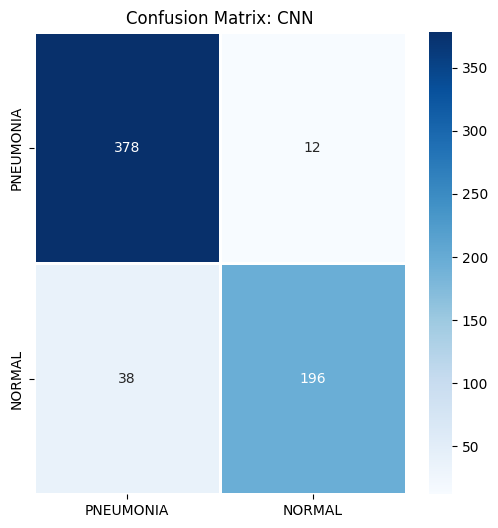

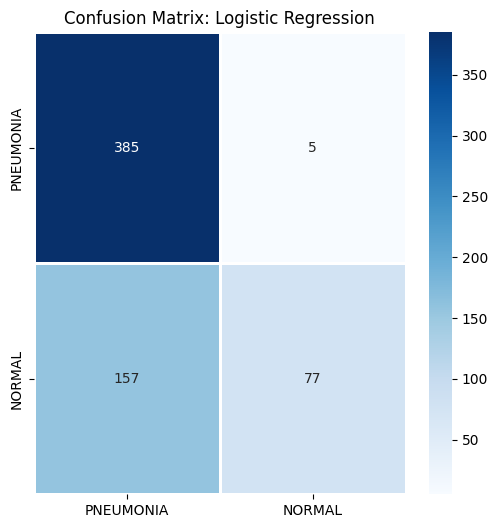

In [10]:
# Confusion Matrix for CNN
cm_cnn = confusion_matrix(y_test, cnn_preds)
cm_cnn_df = pd.DataFrame(cm_cnn, index=labels, columns=labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_cnn_df, annot=True, fmt='d', cmap='Blues', linewidths=1)
plt.title('Confusion Matrix: CNN')
plt.show()
# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr_df = pd.DataFrame(cm_lr, index=labels, columns=labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_lr_df, annot=True, fmt='d', cmap='Blues', linewidths=1)
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

In [11]:
# Classification Reports
print("Classification Report for CNN:")
print(classification_report(y_test, cnn_preds, target_names=labels))
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr, target_names=labels))

Classification Report for CNN:
              precision    recall  f1-score   support

   PNEUMONIA       0.91      0.97      0.94       390
      NORMAL       0.94      0.84      0.89       234

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

   PNEUMONIA       0.71      0.99      0.83       390
      NORMAL       0.94      0.33      0.49       234

    accuracy                           0.74       624
   macro avg       0.82      0.66      0.66       624
weighted avg       0.80      0.74      0.70       624



Logistic Regression Test Accuracy: 74.04%
SVM Test Accuracy: 75.32%


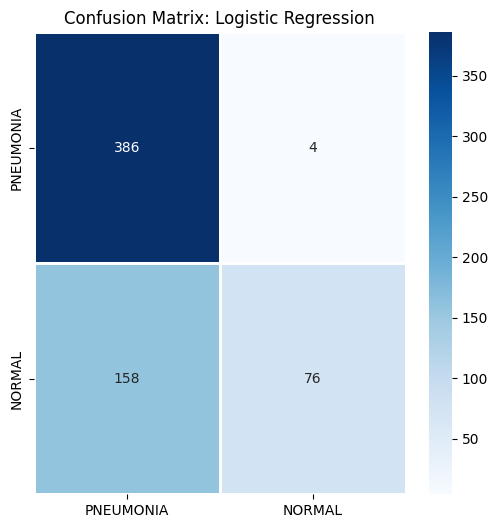

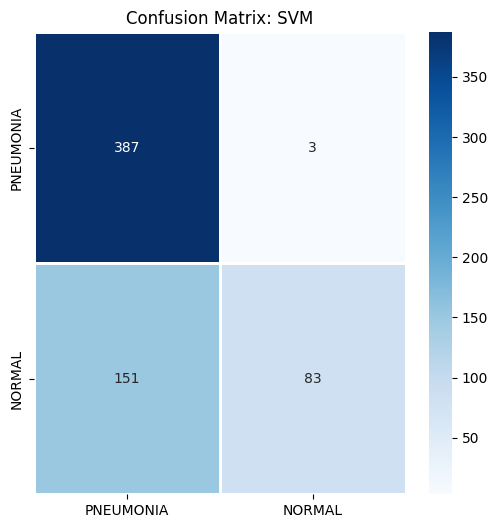

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

   PNEUMONIA       0.71      0.99      0.83       390
      NORMAL       0.95      0.32      0.48       234

    accuracy                           0.74       624
   macro avg       0.83      0.66      0.66       624
weighted avg       0.80      0.74      0.70       624

Classification Report for SVM:
              precision    recall  f1-score   support

   PNEUMONIA       0.72      0.99      0.83       390
      NORMAL       0.97      0.35      0.52       234

    accuracy                           0.75       624
   macro avg       0.84      0.67      0.68       624
weighted avg       0.81      0.75      0.72       624



In [12]:
# Logistic Regression without PCA
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)

# Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, solver='liblinear', C=1.0)
lr_model.fit(x_train_flat, y_train)

# Predict with Logistic Regression
y_pred_lr = lr_model.predict(x_test_flat)

# Evaluate Logistic Regression
print(f"Logistic Regression Test Accuracy: {np.mean(y_test == y_pred_lr) * 100:.2f}%")

# SVM Model
from sklearn.svm import SVC

# Train an SVM model on flattened data (no PCA)
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(x_train_flat, y_train)

# Predict with SVM
y_pred_svm = svm_model.predict(x_test_flat)

# Evaluate SVM
print(f"SVM Test Accuracy: {np.mean(y_test == y_pred_svm) * 100:.2f}%")

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr_df = pd.DataFrame(cm_lr, index=labels, columns=labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_lr_df, annot=True, fmt='d', cmap='Blues', linewidths=1)
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_svm_df = pd.DataFrame(cm_svm, index=labels, columns=labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_svm_df, annot=True, fmt='d', cmap='Blues', linewidths=1)
plt.title('Confusion Matrix: SVM')
plt.show()

# Classification Reports
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr, target_names=labels))

print("Classification Report for SVM:")
print(classification_report(y_test, y_pred_svm, target_names=labels))


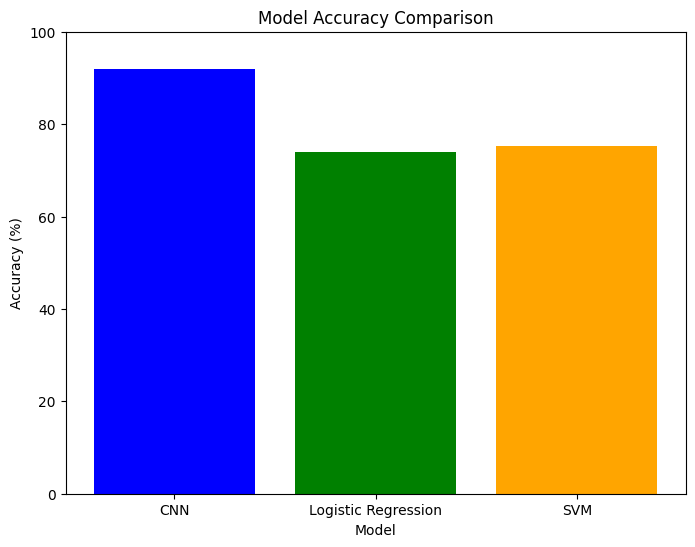

In [13]:
# Accuracy Comparison Graph
models = ['CNN', 'Logistic Regression', 'SVM']
accuracies = [accuracy * 100, np.mean(y_test == y_pred_lr) * 100, np.mean(y_test == y_pred_svm) * 100]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


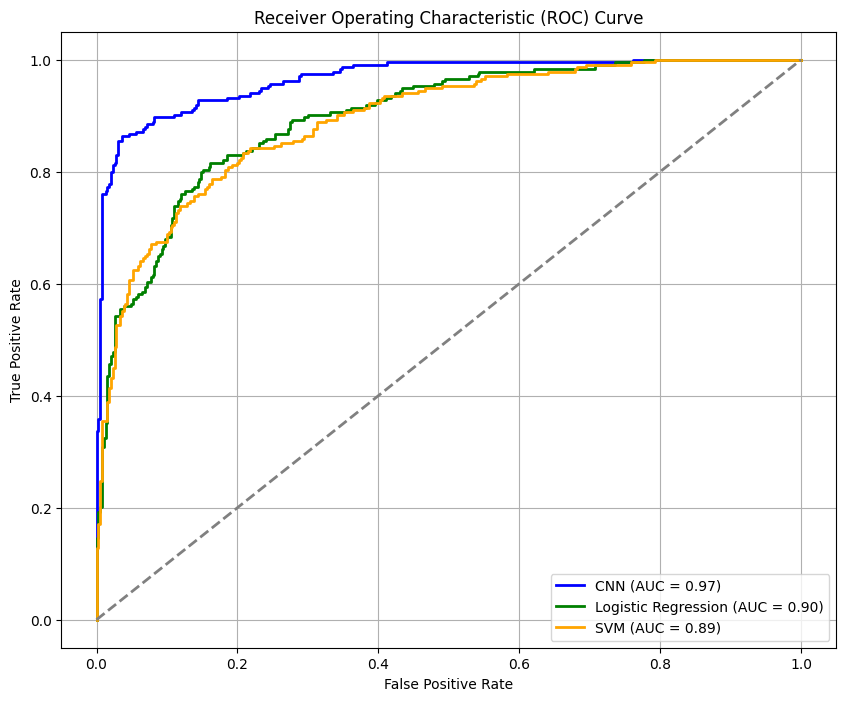

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer


#%%

# Compute ROC Curve and AUC for CNN (using flattened predictions)
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, model.predict(x_test).flatten())
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# Compute ROC Curve and AUC for Logistic Regression (using flattened data)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr_model.predict_proba(x_test_flat)[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Compute ROC Curve and AUC for SVM (using flattened data)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_model.decision_function(x_test_flat))
roc_auc_svm = auc(fpr_svm, tpr_svm)

#%%

# Plot ROC Curve for all models
plt.figure(figsize=(10, 8))

# Plot ROC curve for CNN
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, label=f'CNN (AUC = {roc_auc_cnn:.2f})')

# Plot ROC curve for Logistic Regression
plt.plot(fpr_lr, tpr_lr, color='green', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')

# Plot ROC curve for SVM
plt.plot(fpr_svm, tpr_svm, color='orange', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Customize the plot
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [15]:
import pickle

# Save Logistic Regression model
with open('/kaggle/working/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

# Save PCA transformer (if used)
with open('/kaggle/working/pca_transformer.pkl', 'wb') as f:
    pickle.dump(pca, f)

print("Logistic Regression and PCA models saved successfully.")

# Save SVM model
with open('/kaggle/working/svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

print("SVM model saved successfully.")

# Save the CNN model (Keras)
model.save('/kaggle/working/cnn_model.h5')

print("CNN model saved successfully.")


Logistic Regression and PCA models saved successfully.
SVM model saved successfully.
CNN model saved successfully.
